# V.1 Exploring the green reds

### a) Write a function that will plot a scatterplot matrix of your red wine data.

In [785]:
import random
import math

import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import pandas as pd
import numpy as np

In [786]:
try:
    wine_data = pd.read_csv('resources/winequality-red.csv', sep=';')
except FileNotFoundError:
    print('Set correct path')

In [787]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):

    num_examples, num_fitures = wine_data.shape
    fiture_names = wine_data.columns

    fig, axes = plt.subplots(num_fitures, num_fitures, figsize=(25, 25))
    fig.subplots_adjust(wspace=0, hspace=0)

    good_wines = wine_data[wine_data['quality'] > good_threshold]
    bad_wines = wine_data[wine_data['quality'] < bad_threshold]
    
    for x in axes.flat:
        x.xaxis.set_visible(False)
        x.yaxis.set_visible(False)

    for i, label in enumerate(fiture_names):
        axes[i, i].annotate(label.replace(' ', '\n'), (0.5, 0.5), va='center', ha='center', size=20, xycoords='axes fraction')
    
    for i in range(num_fitures):
        for j in range(i + 1, num_fitures):
            axes[i, j].scatter(good_wines[str(fiture_names[j])], good_wines[str(fiture_names[i])], marker='.', c='g', s=7)
            axes[i, j].scatter(bad_wines[str(fiture_names[j])], bad_wines[str(fiture_names[i])], marker='.', c='r', s=7)
            axes[j, i].scatter(good_wines[str(fiture_names[i])], good_wines[str(fiture_names[j])], marker='.', c='g', s=7)
            axes[j, i].scatter(bad_wines[str(fiture_names[i])], bad_wines[str(fiture_names[j])], marker='.', c='r', s=7)

    if save_plot == True:
        fig.savefig('wine_data.png')
    
    return fig

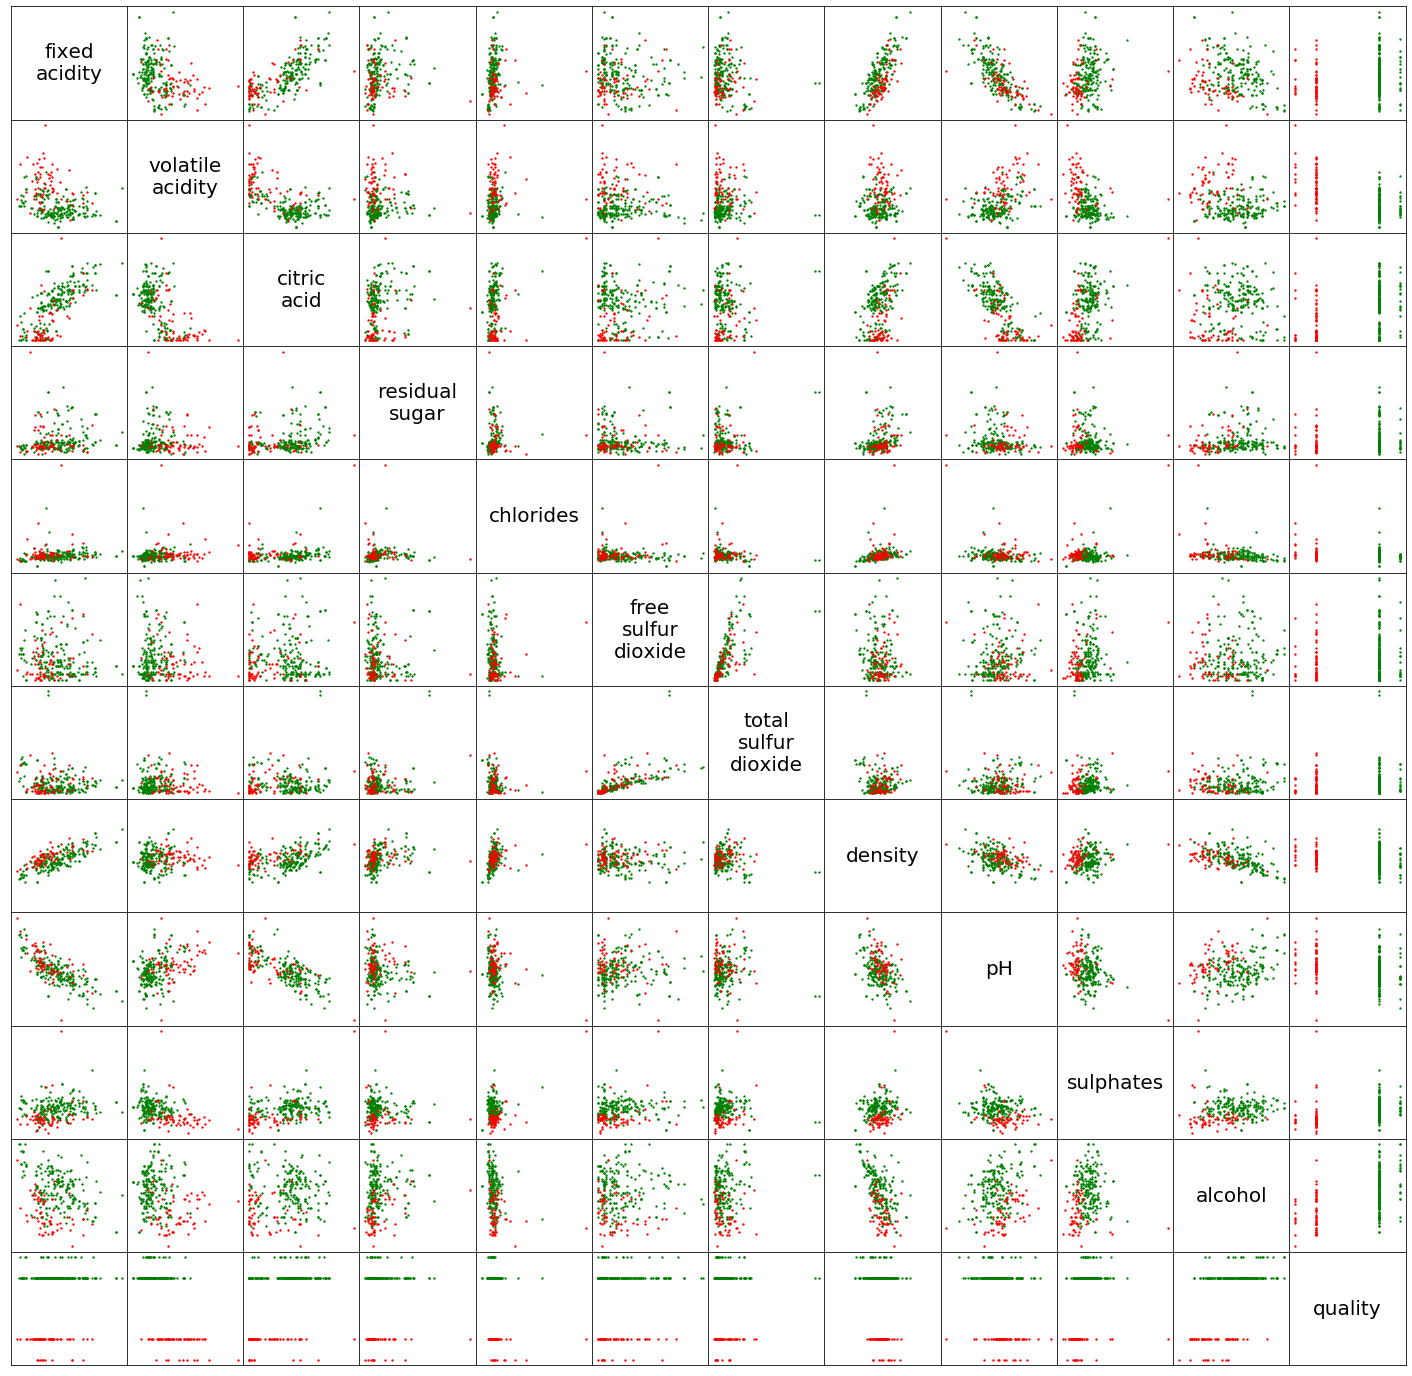

In [788]:
fig = plot_scatter_matrix(wine_data, 6, 5, True)
plt.show(fig)

### b) Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

Нам подходят все сочетания этих хим. элементов:
- Sulphates
- Alcohol
- Volatile acidity

Поскольку отобразив зависимость качества вина от различных сочетаний описанных химических элементов, можно сделать
вывод, что сочетания с вышеперечисленными химическими элементами наиболее визуально разделимые.

# V.2 Learning to perceptron

### a) Implement a perceptron that:

- Has randomly initialized weights and bias
- Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
- Utilizes the heaviside step activation function (discrete version)

### b) Implement a function for training the perseptron. Training function should take in the red wine data as a parameter and should:

- Have a way to specify number of training epochs
- Train your perceptron until it makes no errors, if training epochs is set to 0
- Have a way to specify learning rate
- Return a list of python tuples containing (performance): [(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]

In [789]:
class MatrixService:
    
    @staticmethod
    def multiply(A, B):
        tmp = [sum(A[0] * B)]
        for col in range(1, len(A)):
            tmp.append(sum(A[col] * B))
        return np.array((tmp))
        
    @staticmethod
    def transpose(A):
        tmp = A[:,0]
        for col in range(1, len(A[0])):
            tmp = np.vstack((tmp, A[:,col]))
        return tmp

In [952]:
class DataService:
    
    def _feature_scaling(self, np_data):
        for i in range(0, np_data.shape[1] - 1):
            np_data[:,i] = (np_data[:,i] - np_data[:,i].min()) / (np_data[:,i].max() - np_data[:,i].min())
        return np_data
    
    def prepare_data(self, data, good_tresh, bad_tresh, feature_scaling=False):
        columns = data.columns
        criteria1 = data['quality'] <= bad_tresh
        criteria2 = data['quality'] >= good_tresh
        data_set = data[criteria1 | criteria2].to_numpy()
        data_set[data_set[:,-1] <= bad_tresh, -1] = 0
        data_set[data_set[:,-1] >= good_tresh, -1] = 1
        if not feature_scaling:
            return pd.DataFrame(data_set, columns=columns)
        return pd.DataFrame(self._feature_scaling(data_set), columns=columns)

    def split_data_simple(self, df, proportion): #proportion: 0.0-1.0 - training data share
        train_len = int(len(df) * proportion)
        return df.loc[:train_len,:], df.loc[train_len:,:]
    
    def split_data_k_fold(self, df, k: int):
        fold_size = int(len(df) // k)
        lim_high = fold_size
        lim_low = 0
        result = list()
        for i in range(0, k):
            if i+1 == k:
                result.append((df.loc[:lim_low,:], df.loc[lim_low:,:]))
            else:
                concat_sides = pd.concat([df.loc[:lim_low,:], df.loc[lim_high:,:]])
                result.append((concat_sides, df.loc[lim_low:lim_high,:]))
            lim_low += fold_size
            lim_high += fold_size
        return result
    
    def get_Xy(self, df, f_columns):
        y = df['quality'].to_numpy()
        X = df[f_columns].to_numpy()
        return X, y

    

In [990]:
class BaseModel:

    def calculate_accuracy(self, output, y):
        errors = self.calculate_error(output, y)
        return (len(y) - errors) / len(y)
    
    def calculate_error(self, output, y):
        errors = 0
        for outi, yi in zip(output, y):
            errors += int(outi != yi)
        return errors
    
    def sigmoid_func(self, net_input):
        return np.array([1 / (1 + math.exp(-x)) for x in net_input])

    def hypothesis(self, feature_set, weights, activation_func=None):
        if activation_func:
            return activation_func(np.array([sum(obj) for obj in feature_set * weights[1:]]) + weights[0])
        return np.array([sum(obj) for obj in [feature * weights[1:] for feature in feature_set]]) + weights[0]

    def heaviside_func(self, h):
        return np.where(h < 0, 0, 1)
    
    def sigmoid_discrete_func(self, output):
        return np.where(output > 0.5, 1, 0)
    

In [792]:
class Perseptron(BaseModel):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def train(self, l_rate=0.001, epochs=0):
        epoch = 0
        result = list()
        weights = [random.choice([x/1000 for x in range(-1000, 1000)]) for _ in range(X.shape[1] + 1)]
        while True:
            errors = 0
            epoch += 1
            if epochs == epoch:
                return result
            for xi, yi in zip(self.X, self.y):
                update = (yi - self.hypothesis(np.array([xi]), weights, activation_func=self.heaviside_func)) * l_rate
                weights[1:] += update * xi
                weights[0] += update
                errors += int(update != 0.0)
            if epochs == 0:
                if errors == 0:
                    return result
            result.append((epoch, errors, weights[1:], weights[0]))
            


### c) Write a function that will take the output of the perceptron training function and the red wine data and generate two plots in one figure:

- The first plot should plot the number of errors the perceptron made as a function of epoch. Be careful with how you calculate errors
- The second plot should plot the decision boundary of your perceptron and also show 'good' and 'bad' wine data points on the final training epoch. This second plot should also shade 'good' and 'bad' areas
- The function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch

In [884]:
def decision_boundary(weights, range_):
    slope = -weights[1]/weights[2]
    intercept = -weights[0]/weights[2]
    return [x * slope + intercept for x in range_]

def plot_performance(performance, wine_data, good_tresh, bad_tresh, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    This function will produce a two plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundery for two factors
    """
    wine_data, quality = wine_data[0], wine_data[1]
    wine_data['quality'] = quality
    
    
    good_wines = wine_data[wine_data['quality'] == 1]
    bad_wines = wine_data[wine_data['quality'] == 0]
        
    
#     Data for first plot
    epochs = [curr_epoch[0] for curr_epoch in performance]
    errors = [err[1] for err in performance]
    weights = []
    
    
#     Determine an epoch for second plot
    if epoch == -1 or epoch > performance[-1][0]:
        weights = list(performance[-1][-1]) + performance[-1][-2]
        epoch = performance[-1][0]
    elif epoch >= 0:
        weights = list(performance[epoch-1][-1]) + performance[epoch-1][-2]
        epoch = performance[epoch-1][0]
    
#     Plotting
    fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 4))
    
    plt1.set_title('Errors as a function of epoch')
    plt1.set_xlabel('epoch')
    plt1.set_ylabel('classification errors')
    
    plt2.set_title(f'Decision boundary on epoch: {epoch}')
    plt2.set_xlabel('alcohol')
    plt2.set_ylabel('pH')
    
    xoffset = (wine_data['alcohol'].max() - wine_data['alcohol'].min()) / len(wine_data)
    yoffset = (wine_data['pH'].max() - wine_data['pH'].min()) / len(wine_data)
    plt2.set_xlim(wine_data['alcohol'].min() - xoffset, wine_data['alcohol'].max() + xoffset)
    plt2.set_ylim(wine_data['pH'].min() - yoffset, wine_data['pH'].max() + yoffset)

    plt1.plot(epochs, errors)
    
    plt2.fill_between(decision_boundary(weights, range(-15, 15)),
                      range(-15, 15), -1, facecolor='#6EDD5E', alpha=0.3)
    plt2.fill_between(decision_boundary(weights, range(-15, 15)), range(-15, 15),
                     wine_data['pH'].max()+1, facecolor='#FFB4FA', alpha=0.3)
    
    plt2.scatter(bad_wines['alcohol'], bad_wines['pH'], s=13, color='#FF00F0', label=f'bad wines (>{good_tresh-1} score)')
    plt2.scatter(good_wines['alcohol'], good_wines['pH'], s=13, color='g', label=f'good wines (<{bad_tresh+1} score)')
    
    plt2.plot(decision_boundary(weights, range(-15, 15)), range(-15, 15), '--', label='Decision Boundary')
    plt2.legend(loc=1, bbox_to_anchor=(1.52, 1))


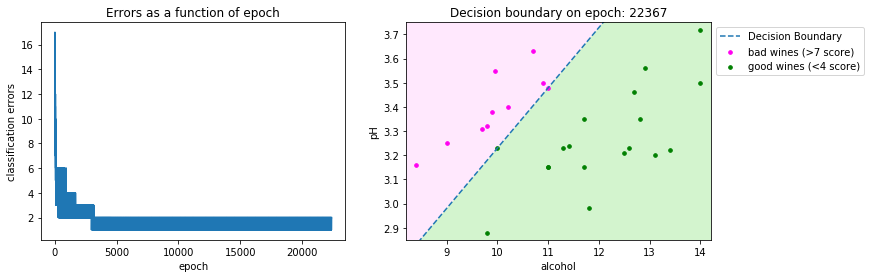

In [811]:
data_service = DataService()

df = data_service.prepare_data(wine_data, good_tresh=8, bad_tresh=3, feature_scaling=False)
X, y = data_service.get_Xy(df, ['pH', 'alcohol'])

perseptron = Perseptron(X, y)

plot_performance(perseptron.train(), [pd.DataFrame(X, columns=['pH', 'alcohol']), y], good_tresh=8, bad_tresh=3)

### d) Adding the feature scaling and using the function that was created in part "c)" to plot and verify that the perceptron is learning more efficiently.

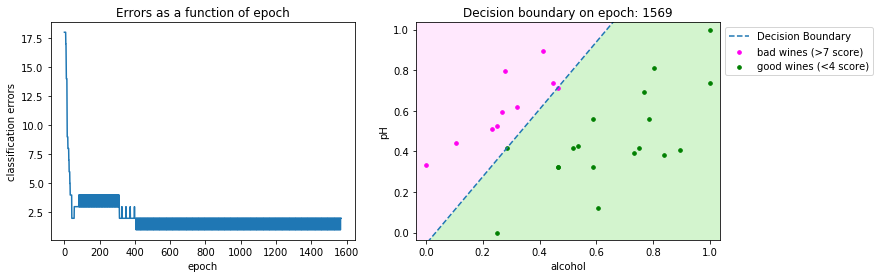

In [810]:
df = data_service.prepare_data(wine_data, good_tresh=8, bad_tresh=3, feature_scaling=True)
X, y = data_service.get_Xy(df, ['pH', 'alcohol'])

perseptron = Perseptron(X, y)

plot_performance(perseptron.train(), [pd.DataFrame(X, columns=['pH', 'alcohol']), y], good_tresh=8, bad_tresh=3)

# V.3 My fair ADALINE

### a) Marvin notices and chides you for torturing your perceptron. Why?

### b) Implement an ADALINE that:
- Has randomly initialized weights and bias
- Uses a linear activation function and some kind of quantizer
- Uses the Widrow-Hoff learning rule

### c) You’ll need to implement a function to train your ADALINE. Your training function should:
- Take in your red wine data as a parameter
- Have a way to specify number of training epochs
- If training epochs is set to 0, your ADALINE should train until it converges on a good set of weights.
- Have a way to specify learning rate.
- Have an option to perform either online learning or batch learning

In [984]:
class Adaline(BaseModel):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.w = None
        self.ms = MatrixService()
    
    def _train_stochastic_mode(self, l_rate):
        for xi, yi in zip(self.X, self.y):
            outi = self.hypothesis(np.array([xi]), self.w, activation_func=self.sigmoid_func)
            error = yi - outi
            self.w[0] += l_rate * error
            self.w[1:] += l_rate * error * xi
    
    def _train_batch_mode(self, l_rate):
        output = self.hypothesis(self.X, self.w, activation_func=self.sigmoid_func)
        errors = self.y - output
        self.w[0] += l_rate * np.array([errors.sum()])
        self.w[1:] += l_rate * self.ms.multiply(self.ms.transpose(self.X), errors) # X.T.dot(errors) * l_rate
#         cost = (errors**2).sum() / 2
    
    def train(self, mode="batch", seed=None, l_rate=0.01, epochs=0):
        if mode != "batch" and mode != "stochastic":
            raise ValueError("Correct modes are: 'batch' and 'stochastic'.")
        if epochs < 0:
            raise ValueError("'epochs' can't be a negative number.")
        if seed:
            random.seed(seed)
        self.w = [random.choice([x/1000 for x in range(-1000, 1000)]) for _ in range(X.shape[1] + 1)]
        epoch = 0
        result = list()
        while True:
            if mode == "stochastic":
                self._train_stochastic_mode(l_rate)
            elif mode == "batch":
                self._train_batch_mode(l_rate)
            output = self.hypothesis(self.X, self.w, activation_func=self.sigmoid_func)
            a_output = self.sigmoid_discrete_func(output)
            errors = self.calculate_error(a_output, self.y)
            result.append((epoch, errors, self.w[1:], self.w[0]))
            if errors == 0:
                return result
            if epochs == epoch and epoch != 0:
                return result
            else:
                epoch += 1
            

### d) Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary of your ADALINE. What settings tend to give the smallest number of classification errors? Support your reasoning with example plots!

In [978]:
good_treshold = 7
bad_treshold = 4

In [979]:
data_service = DataService()

df = data_service.prepare_data(wine_data, good_tresh=good_treshold, bad_tresh=bad_treshold, feature_scaling=True)
X, y = data_service.get_Xy(df, ['pH', 'alcohol'])

In [985]:
temp = 100
optimal = ()
for lr in np.arange(0.000, 0.1, step=0.005):
    adaline = Adaline(X, y)
    result = adaline.train(mode="batch", epochs=1000, l_rate=lr)
    min_errors = min([x[1] for x in result]), result[-1][1]
    avrg_res = (sum(min_errors) + lr) / 3
    if avrg_res < temp:
        temp = avrg_res
        optimal = (lr, min_errors)
    print(f"lr: {lr}, absolutely min: {min_errors[0]}, last min: {min_errors[1]}")
print(f"""
------------------------------------------------------------------
Optimal learning rate is: {optimal[0]}
Marks: (absolutely min: {optimal[1][0]}, last min: {optimal[1][1]})
------------------------------------------------------------------
""")

lr: 0.0, absolutely min: 220, last min: 220
lr: 0.005, absolutely min: 36, last min: 39
lr: 0.01, absolutely min: 37, last min: 39
lr: 0.015, absolutely min: 36, last min: 39
lr: 0.02, absolutely min: 36, last min: 39
lr: 0.025, absolutely min: 36, last min: 39
lr: 0.03, absolutely min: 37, last min: 39


KeyboardInterrupt: 

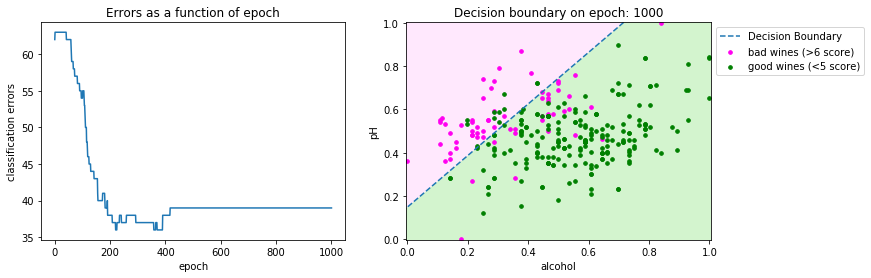

In [986]:
adaline = Adaline(X, y)
plot_performance(adaline.train(mode="batch", epochs=1000, l_rate=optimal[0]),
    [pd.DataFrame(X, columns=['pH', 'alcohol']), y], good_tresh=good_treshold, bad_tresh=bad_treshold)

# V.4 Advanced wine sampling and resampling

### a) Write a function that uses the holdout method to partition the red wine data into a training and a validation set. The function should take a parameter to adjust the proportion of training to validation data. It should return a tuple containing:               (training_pandas_dataframe, validation_pandas_dataframe)

In [1000]:
data_service = DataService()

df = data_service.prepare_data(wine_data, good_tresh=good_treshold, bad_tresh=bad_treshold, feature_scaling=True)
df_train, df_test = data_service.split_data_simple(df, 0.8)

### b) Write a function that generates a k-fold cross-validation dataset from the red wine data. The function should allow k to be arbitrarily adjusted and also have an optional setting to shuffle data before creating k-folds. The function should return a list of ‘k’ tuples with each tuple containing:  (training_pandas_dataframe, cross_validation_pandas_dataframe)

In [1004]:
data_service = DataService()
k_fold = 5

df = data_service.prepare_data(wine_data, good_tresh=good_treshold, bad_tresh=bad_treshold, feature_scaling=True)
df_k_folds = data_service.split_data_k_fold(df, k_fold)

### c) What effects does changing learning rate and number of training epochs have on the ADALINE when evaluated via k-fold cross-validation? To address this question, you should write (or modify) a function that will train and assess the ADALINE on each training and cross-validation fold produced by your k-fold function.

In [1005]:
bm = BaseModel()
accuracy = 0
for k in range(k_fold):
    X_train, y_train = data_service.get_Xy(df_k_folds[k][0], ['pH', 'alcohol'])
    X_test, y_test = data_service.get_Xy(df_k_folds[k][1], ['pH', 'alcohol'])
    adaline = Adaline(X_train, y_train)
    adaline.train(mode="batch", epochs=300, l_rate=0.005)
    output_test = bm.hypothesis(X_test, adaline.w, activation_func=bm.sigmoid_func)
    output_test = bm.sigmoid_discrete_func(output_test)
    accuracy += bm.calculate_accuracy(output_test, y_test)
print(f"k_fold: {k_fold}, Average ADALINE accuracy: {accuracy/k_fold}")

k_fold: 5, Average ADALINE accuracy: 0.844611528822055
